In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Summary
Cleaning and processing of the features provided by the data set
First supervised models tested to infer the 70 top categories (with a one vs all approach for one label at a time). SVM and logistic regression tested, they don't manage to catch any signal, ie their result is the same than the one of the baseline.

## 1 Loading the data
NB: the json need to be a list of json elements as dictionary. We need to add the **brackets []** and the **coma** to separate each element

In [2]:
with open("../yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json") as json_file:
    data_business = json.load(json_file)


In [3]:
data_business[35]

{u'attributes': {u'Accepts Credit Cards': True,
  u'Alcohol': u'full_bar',
  u'Ambience': {u'casual': True,
   u'classy': False,
   u'divey': False,
   u'hipster': False,
   u'intimate': False,
   u'romantic': False,
   u'touristy': False,
   u'trendy': False,
   u'upscale': False},
  u'Attire': u'casual',
  u'BYOB': False,
  u'BYOB/Corkage': u'yes_free',
  u'Caters': False,
  u'Corkage': False,
  u'Delivery': False,
  u'Good For': {u'breakfast': False,
   u'brunch': False,
   u'dessert': False,
   u'dinner': False,
   u'latenight': True,
   u'lunch': False},
  u'Good For Groups': True,
  u'Good For Kids': False,
  u'Good for Kids': True,
  u'Has TV': True,
  u'Noise Level': u'very_loud',
  u'Outdoor Seating': False,
  u'Parking': {u'garage': False,
   u'lot': True,
   u'street': False,
   u'valet': False,
   u'validated': False},
  u'Price Range': 2,
  u'Take-out': True,
  u'Takes Reservations': True,
  u'Waiter Service': True,
  u'Wheelchair Accessible': True},
 u'business_id': u'sbW

Somes features need to be droped:
* 'full_address', 'city': the state and latitude/longitude already stand for the geographical position. Maybe the street could eb considered, but then will need to be convert...
* 'name': need to find how to use it (add features count to find a word realted to categories in the name?)
* 'type': stands for the data type (here it's business)

Somes features are droped but may be useful, we need to think about how to use them:
* 'attributes': issue is the unstructured nature
* 'hours': the checkin seems to be enough
* 'neighborhoods': many missing values in this column

In [4]:
business_list = []
    
for b in data_business:
    d = b.copy()
    
    # Dropping unconsidered features
    d.pop('hours')
    #d.pop('attributes')
    d.pop('neighborhoods')
    d.pop('type')
    d.pop('full_address')
    d.pop('name')
    #d.pop('city')
    
    
    business_list.append(d)
    
business=pd.DataFrame(business_list)
# Changing the index
business = business.set_index('business_id')

business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61184 entries, vcNAWiLM4dR7D2nwwJ7nCA to 2EKGrbf2_81MrtjKZeOTng
Data columns (total 9 columns):
attributes      61184 non-null object
categories      61184 non-null object
city            61184 non-null object
latitude        61184 non-null float64
longitude       61184 non-null float64
open            61184 non-null bool
review_count    61184 non-null int64
stars           61184 non-null float64
state           61184 non-null object
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 4.3+ MB


# City filtering
First test with Las Vegas

In [5]:
# Load the business id of Las Vegas restaurants
lasvegas_id = np.load('temp/Lasvegas_data/lasvegas_id.npy')
len(lasvegas_id)

3822

In [6]:
# Filtering the businesses
business_lasvegas = business[business.index.isin(lasvegas_id)]
print len(business_lasvegas)
business_lasvegas.head(2)

3822


,attributes,categories,city,latitude,longitude,open,review_count,stars,state
business_id,,,,,,,,,
l6QcUE8XXLrVH6Ydm4GSNw,"{u'Drive-Thru': False, u'Alcohol': u'none', u'...","[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197365,-115.191711,True,13,3,NV
AgtFQVxo-PGQVsOdY6Nvdg,"{u'Take-out': True, u'Alcohol': u'none', u'Has...","[Pizza, Restaurants]",Las Vegas,36.173110,-115.125401,True,3,4,NV


# Checkin data

In [7]:
with open("../yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json") as json_file:
    data_checkin = json.load(json_file)


In [8]:
data_checkin[0]

{u'business_id': u'cE27W9VPgO88Qxe4ol6y_g',
 u'checkin_info': {u'10-0': 1,
  u'13-0': 1,
  u'13-3': 1,
  u'14-6': 1,
  u'17-3': 1,
  u'17-6': 1,
  u'18-4': 1,
  u'7-5': 1,
  u'9-5': 1},
 u'type': u'checkin'}

In [9]:
checkin_list = []

for c in data_checkin:
    d = {}
    d['business_id'] = c['business_id']
    for k,v in c['checkin_info'].iteritems():
        d[k] = v
    checkin_list.append(d)
    
checkin=pd.DataFrame(checkin_list)
checkin = checkin.set_index('business_id')

# Change Nan to 0 in the checking
checkin = checkin.fillna(0)

checkin.head(10)

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,1-0,1-1,1-2,...,8-4,8-5,8-6,9-0,9-1,9-2,9-3,9-4,9-5,9-6
business_id,,,,,,,,,,,,,,,,,,,,,
cE27W9VPgO88Qxe4ol6y_g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
mVHrayjG3uZ_RLHkLj-AMg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
KayYbHCt-RkbGcPdGOThNg,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,3,0,0
wJr6kSA5dchdgOdwH6dZ2w,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
yXuao0pFz1AxB21vJjDf5w,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
fNGIbpazjTRdXgwRY_NIXA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
b9WZJp5L1RZr4F1nxclOoQ,0,0,0,0,0,0,0,0,0,0,...,2,3,4,2,3,1,2,4,4,1
zaXDakTd3RXyOa7sMrUE1g,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,0
zgy27FSnvwdINfk5cXBIyQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
# ## Joining the dataframes
business_lasvegas_df = business_lasvegas.merge(checkin, how='left', right_index=True, left_index=True)
business_lasvegas_df.head(2)

,attributes,categories,city,latitude,longitude,open,review_count,stars,state,0-0,...,8-4,8-5,8-6,9-0,9-1,9-2,9-3,9-4,9-5,9-6
business_id,,,,,,,,,,,,,,,,,,,,,
l6QcUE8XXLrVH6Ydm4GSNw,"{u'Drive-Thru': False, u'Alcohol': u'none', u'...","[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197365,-115.191711,True,13,3,NV,0,...,0,0,0,0,0,0,0,0,0,0
AgtFQVxo-PGQVsOdY6Nvdg,"{u'Take-out': True, u'Alcohol': u'none', u'Has...","[Pizza, Restaurants]",Las Vegas,36.173110,-115.125401,True,3,4,NV,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Droping the business with Nan values of checkin
business_lasvegas_df = business_lasvegas_df.dropna(how='any')
len(business_lasvegas_df)

3822

In [12]:
business_lasvegas_df.categories

business_id
l6QcUE8XXLrVH6Ydm4GSNw    [Burgers, American (Traditional), Fast Food, R...
AgtFQVxo-PGQVsOdY6Nvdg                                 [Pizza, Restaurants]
AFDFOs2GaIyUArGyEUDQzQ                               [Chinese, Restaurants]
FV16IeXJp2W6pnghTz2FAw                   [Vietnamese, Chinese, Restaurants]
cvJDHk1ho0DxaF26etcr8Q                        [Latin American, Restaurants]
10UcN8MF1kQiyTJAfHKvfQ            [Delis, Italian, Sandwiches, Restaurants]
R5e2XWtpa_CA77MIXEyCTg                 [Fast Food, Sandwiches, Restaurants]
CoJivG0wxNIBXyOF7MNqSQ                            [Vietnamese, Restaurants]
pCobXgTy6DIfBaT4pjlq0w                            [Sandwiches, Restaurants]
JgpKLikZPbbXYPtILy3-wg               [Latin American, Mexican, Restaurants]
9-O8qKGQQCYXdBlj4iv7bw                               [Restaurants, Italian]
PsOvURXqpy8iZX2J8y429A                               [Seafood, Restaurants]
Yq8LiVymGA7vBpGCQuDfRw                            [Vietnamese, Restaurants]


## 2 Restriction on restaurants: 

In [13]:
# Restricting to the restaurants
restaurants = business_df[business_df['categories'].apply(lambda x: 'Restaurants' in x)]

NameError: name 'business_df' is not defined

In [12]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18640 entries, mVHrayjG3uZ_RLHkLj-AMg to qrgod2lrYnxHwNWC_YYTyQ
Columns: 176 entries, attributes to 9-6
dtypes: bool(1), float64(171), int64(1), object(3)
memory usage: 25.0+ MB


# Categories

In [14]:
from collections import Counter

restaurant_categories = business_lasvegas_df.categories.values
categories_list = [c for cs in restaurant_categories for c in cs]
c = Counter(categories_list)
restaurant_categories_set = set(categories_list)
len(restaurant_categories_set)

# Keeping only the top categories (appear more than 10 times)
top_categories = {k: v for k, v in c.iteritems() if v>10} 
len(top_categories)

# Get ridd of 'Restaurants' category
top_categories.pop('Restaurants')

top_categories

{u'American (New)': 280,
 u'American (Traditional)': 403,
 u'Arts & Entertainment': 45,
 u'Asian Fusion': 91,
 u'Bagels': 12,
 u'Bakeries': 36,
 u'Barbeque': 93,
 u'Bars': 322,
 u'Beer, Wine & Spirits': 19,
 u'Breakfast & Brunch': 156,
 u'Buffets': 88,
 u'Burgers': 296,
 u'Cafes': 97,
 u'Cajun/Creole': 16,
 u'Casinos': 25,
 u'Chicken Wings': 85,
 u'Chinese': 286,
 u'Cocktail Bars': 14,
 u'Coffee & Tea': 43,
 u'Delis': 85,
 u'Desserts': 32,
 u'Dim Sum': 15,
 u'Diners': 49,
 u'Event Planning & Services': 20,
 u'Fast Food': 553,
 u'Filipino': 37,
 u'Food': 257,
 u'Food Delivery Services': 11,
 u'Food Stands': 33,
 u'Food Trucks': 20,
 u'French': 31,
 u'Gluten-Free': 20,
 u'Greek': 32,
 u'Grocery': 11,
 u'Hawaiian': 57,
 u'Hot Dogs': 57,
 u'Ice Cream & Frozen Yogurt': 16,
 u'Indian': 26,
 u'Italian': 232,
 u'Japanese': 201,
 u'Juice Bars & Smoothies': 29,
 u'Karaoke': 13,
 u'Korean': 65,
 u'Latin American': 29,
 u'Lounges': 41,
 u'Mediterranean': 68,
 u'Mexican': 476,
 u'Middle Eastern': 2

In [15]:
# Keeping only the best categories

def filter_categories(categories, top_categories):
    new_categories = []
    for c in categories:
        if c in top_categories:
            new_categories.append(c)
    return new_categories

business_lasvegas_df['categories_top'] = business_lasvegas_df.apply(lambda x: filter_categories(x['categories'], top_categories.keys()), axis=1)


In [16]:
# Removing the restaurants without categories in top categories

business_lasvegas_df['num_cat'] = business_lasvegas_df.apply(lambda x: len(x['categories_top']), axis=1)
restaurants_lasvegas = business_lasvegas_df[business_lasvegas_df.num_cat > 0]

business_lasvegas_df

,attributes,categories,city,latitude,longitude,open,review_count,stars,state,0-0,...,8-6,9-0,9-1,9-2,9-3,9-4,9-5,9-6,categories_top,num_cat
business_id,,,,,,,,,,,,,,,,,,,,,
l6QcUE8XXLrVH6Ydm4GSNw,"{u'Drive-Thru': False, u'Alcohol': u'none', u'...","[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197365,-115.191711,True,13,3.0,NV,0,...,0,0,0,0,0,0,0,0,"[Burgers, American (Traditional), Fast Food]",3
AgtFQVxo-PGQVsOdY6Nvdg,"{u'Take-out': True, u'Alcohol': u'none', u'Has...","[Pizza, Restaurants]",Las Vegas,36.173110,-115.125401,True,3,4.0,NV,0,...,0,0,0,0,0,0,0,0,[Pizza],1
AFDFOs2GaIyUArGyEUDQzQ,"{u'Alcohol': u'beer_and_wine', u'Noise Level':...","[Chinese, Restaurants]",Las Vegas,36.125908,-115.197904,True,155,3.0,NV,13,...,0,0,0,0,0,0,0,1,[Chinese],1
FV16IeXJp2W6pnghTz2FAw,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Vietnamese, Chinese, Restaurants]",Las Vegas,36.126177,-115.193971,True,1514,3.5,NV,51,...,26,18,11,19,10,9,27,41,"[Vietnamese, Chinese]",2
cvJDHk1ho0DxaF26etcr8Q,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Latin American, Restaurants]",Las Vegas,36.142935,-115.207747,True,48,3.5,NV,0,...,0,0,0,0,0,0,0,0,[Latin American],1
10UcN8MF1kQiyTJAfHKvfQ,{u'Accepts Credit Cards': True},"[Delis, Italian, Sandwiches, Restaurants]",Las Vegas,36.145672,-115.187809,True,3,5.0,NV,0,...,0,0,0,0,0,1,0,0,"[Delis, Italian, Sandwiches]",3
R5e2XWtpa_CA77MIXEyCTg,"{u'Delivery': False, u'Accepts Credit Cards': ...","[Fast Food, Sandwiches, Restaurants]",Las Vegas,36.130335,-115.206002,True,5,2.5,NV,0,...,0,0,0,0,0,0,0,0,"[Fast Food, Sandwiches]",2
CoJivG0wxNIBXyOF7MNqSQ,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Vietnamese, Restaurants]",Las Vegas,36.126378,-115.196994,True,65,3.0,NV,0,...,0,0,0,0,1,0,2,1,[Vietnamese],1
pCobXgTy6DIfBaT4pjlq0w,"{u'Take-out': True, u'Accepts Credit Cards': T...","[Sandwiches, Restaurants]",Las Vegas,36.143005,-115.208009,True,32,3.0,NV,0,...,8,12,8,7,6,8,17,9,[Sandwiches],1


# Attributes

In [17]:
# Study on the attributes

attributes_keys = [k for attributes in restaurants_lasvegas.attributes.values for k in attributes.keys()]
len(attributes_keys)

counter_att = Counter(attributes_keys)

# Keep the top attributes
top_attributes = {k: v for k, v in counter_att.iteritems() if v > len(restaurants_lasvegas)/2} 
print len(top_attributes)
top_attributes

19


{u'Accepts Credit Cards': 3664,
 u'Alcohol': 3313,
 u'Ambience': 3250,
 u'Attire': 3591,
 u'Caters': 2804,
 u'Delivery': 3535,
 u'Good For': 3442,
 u'Good For Groups': 3605,
 u'Good for Kids': 3618,
 u'Has TV': 3395,
 u'Noise Level': 3199,
 u'Outdoor Seating': 3531,
 u'Parking': 3343,
 u'Price Range': 3632,
 u'Take-out': 3615,
 u'Takes Reservations': 3567,
 u'Waiter Service': 3356,
 u'Wheelchair Accessible': 2018,
 u'Wi-Fi': 2920}

In [18]:
# Values for different attributes
attributes_set = set()
def get_attribute(attributes, attribute, attributes_set):
    if attribute in attributes:
        val = attributes[attribute]
        if not isinstance(val, dict):
            return val
        else:
            attributes_set.add(attribute)
            return 'dict'
    return np.nan

# Setting the attribute columns
for attribute in top_attributes:
    restaurants_lasvegas[attribute] = restaurants_lasvegas.apply(lambda x: get_attribute(x.attributes, attribute, attributes_set) , axis=1)
attributes_set         

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{u'Ambience', u'Good For', u'Parking'}

In [19]:
# Removing Attributes which are dictionary
for at in attributes_set:
    restaurants_lasvegas = restaurants_lasvegas.drop([at], axis=1)
    top_attributes.pop(at)

In [20]:
# Handling missing values in attributes: replacing with the most frequent value
fill_attribute_dict = {}
for attribute in top_attributes:
    fill_attribute_dict[attribute] = restaurants_lasvegas[attribute].value_counts().idxmax()
restaurants_lasvegas = restaurants_lasvegas.fillna(fill_attribute_dict)

In [21]:
# To find categorical features
def is_categorical(unique):
    if len(unique) > 2 and not isinstance(unique[0], float) and not isinstance(unique[0], bool) and not isinstance(unique[0], int):
        return True
    else:
        return False

# Listing the categorical features
categorical = []
for col in restaurants_lasvegas.columns.values:
    if col == 'attributes' or col=='categories' or col=='categories_top':
        continue
    if is_categorical(restaurants_lasvegas[col].unique()):
        categorical.append(col)
categorical

[u'Wi-Fi', u'Alcohol', u'Noise Level', u'Attire']

In [22]:
# Handling categorical feature: state
for c in categorical:
    restaurants_lasvegas[c] = restaurants_lasvegas[c].astype('category')
    dummies = pd.get_dummies(restaurants_lasvegas[c])
    restaurants_lasvegas = restaurants_lasvegas.join(dummies)
    restaurants_lasvegas = restaurants_lasvegas.drop([c], axis=1)

In [23]:
restaurants_lasvegas = restaurants_lasvegas.drop(['attributes'], axis=1)

In [24]:
restaurants_lasvegas['review_count'].max()

4578

In [25]:
restaurants_lasvegas

,categories,city,latitude,longitude,open,review_count,stars,state,0-0,0-1,...,beer_and_wine,full_bar,none,average,loud,quiet,very_loud,casual,dressy,formal
business_id,,,,,,,,,,,,,,,,,,,,,
l6QcUE8XXLrVH6Ydm4GSNw,"[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197365,-115.191711,True,13,3.0,NV,0,0,...,0,0,1,0,0,0,1,1,0,0
AgtFQVxo-PGQVsOdY6Nvdg,"[Pizza, Restaurants]",Las Vegas,36.173110,-115.125401,True,3,4.0,NV,0,0,...,0,0,1,1,0,0,0,1,0,0
AFDFOs2GaIyUArGyEUDQzQ,"[Chinese, Restaurants]",Las Vegas,36.125908,-115.197904,True,155,3.0,NV,13,4,...,1,0,0,1,0,0,0,1,0,0
FV16IeXJp2W6pnghTz2FAw,"[Vietnamese, Chinese, Restaurants]",Las Vegas,36.126177,-115.193971,True,1514,3.5,NV,51,50,...,1,0,0,1,0,0,0,1,0,0
cvJDHk1ho0DxaF26etcr8Q,"[Latin American, Restaurants]",Las Vegas,36.142935,-115.207747,True,48,3.5,NV,0,0,...,0,1,0,0,0,0,1,1,0,0
10UcN8MF1kQiyTJAfHKvfQ,"[Delis, Italian, Sandwiches, Restaurants]",Las Vegas,36.145672,-115.187809,True,3,5.0,NV,0,0,...,0,0,1,1,0,0,0,1,0,0
R5e2XWtpa_CA77MIXEyCTg,"[Fast Food, Sandwiches, Restaurants]",Las Vegas,36.130335,-115.206002,True,5,2.5,NV,0,0,...,0,0,1,1,0,0,0,1,0,0
CoJivG0wxNIBXyOF7MNqSQ,"[Vietnamese, Restaurants]",Las Vegas,36.126378,-115.196994,True,65,3.0,NV,0,0,...,1,0,0,0,0,1,0,1,0,0
pCobXgTy6DIfBaT4pjlq0w,"[Sandwiches, Restaurants]",Las Vegas,36.143005,-115.208009,True,32,3.0,NV,0,0,...,0,0,1,1,0,0,0,1,0,0


# Supervised learning 

In [26]:
from sklearn.cross_validation import train_test_split

# Setting the category binary indicator
for category in top_categories:
    restaurants_lasvegas[category] = restaurants_lasvegas.apply(lambda x: category in x['categories'], axis=1)

# Cleaning the data from the labels
data_exp = restaurants_lasvegas.reset_index()
data_exp = data_exp.drop(['business_id', 'state', 'city'], axis=1)
data_exp = data_exp.drop(['categories', 'categories_top', 'num_cat'], axis=1)

# Split train/test set
itrain, itest = train_test_split(xrange(data_exp.shape[0]), train_size=0.7)
mask=np.ones(data_exp.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

train_set = data_exp[mask]
test_set = data_exp[~mask]

In [27]:
# Dictionaary of the output for each labels
Y_train = {}
Y_test = {}
for category in top_categories:
    Y_train[category] = train_set[category].values
    Y_test[category] = test_set[category].values

# Features
df_train = train_set.drop(top_categories.keys(), axis=1)
df_test = test_set.drop(top_categories.keys(), axis=1)
X_train = df_train.values.astype(float)
X_test = df_test.values.astype(float)
    
print len(X_train)
print len(X_test)

2620
1123


In [28]:
# Structure of the features for Las vegas
checkin_indices = range(5,173)
indicator_indices = [2] + range(173, len(df_train.columns))
numerical_indices = [0, 1, 3, 4]
len(df_train.columns[indicator_indices])

26

### Exraction of the features from the reviews (lda and nmf)

In [29]:
# CASE OWN LDA 
gamma = np.load('temp/assignment2_lv.npy')

with open('temp/bidtoindex.json', 'r') as f:
    bidtoindex = json.load(f)
bidtoindex_list = [t[0] for t in sorted(bidtoindex.items(), key=lambda x: x[1])]

In [30]:
print gamma.shape
gamma_df = pd.DataFrame(data=gamma, index=bidtoindex_list)
gamma_df.head()

(3822, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
YnIzXtsgQdBy3WtjzOaQMA,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025000,0.025000,0.025,0.025000,0.025,0.025,0.025
8buIr1zBCO7OEcAQSZko7w,0.025000,0.025,0.025,0.025000,0.025,899.716083,0.025,0.025,0.025,0.025,...,1887.631565,0.025,0.025,0.025000,0.025000,0.025,0.025000,0.025,0.025,0.025
yJDSMugu_Pom3pJE8MRrJA,0.025000,0.025,0.025,727.671803,0.025,0.025000,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025000,0.025000,0.025,0.025000,0.025,0.025,0.025
3bwxfBvKABepxYWGz3pHXA,1210.945759,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,0.025000,420.264387,0.025,0.025000,0.025,0.025,0.025
s5yzZITWU_RcJzWOgjFecw,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025,0.025,...,0.025000,0.025,0.025,355.082845,0.025000,0.025,841.123792,0.025,0.025,0.025


In [125]:
# CASE PACKAGE LDA
gamma_package = np.load('temp/package_assignement_lv.npy')
gamma_package_df = pd.DataFrame(data=gamma_package, index=bidtoindex_list)

In [172]:
# CASE NMF
gamma_nmf = np.load('temp/nmf_assignments40.npy')
gamma_nmf_df = pd.DataFrame(data=gamma_nmf, index=bidtoindex_list)

In [173]:
# Building the work df
gamma_nmf_exp = restaurants_lasvegas[top_categories.keys()].merge(gamma_df_clean, how='left', right_index=True, left_index=True)

# Cleaning the data from the labels
gamma_nmf_exp = gamma_nmf_exp.reset_index()
gamma_nmf_exp = gamma_nmf_exp.drop(['business_id'], axis=1)

# Dictionaary of the output for each labels
Y_gamma_train = {}
Y_gamma_test = {}
for category in top_categories:
    Y_gamma_train[category] = gamma_nmf_exp[mask][category].values
    Y_gamma_test[category] = gamma_nmf_exp[~mask][category].values

# Features
X_gamma_train_nmf = gamma_nmf_exp[mask].drop(top_categories.keys(), axis=1).values.astype(float)
X_gamma_test_nmf = gamma_nmf_exp[~mask].drop(top_categories.keys(), axis=1).values.astype(float)

print len(X_gamma_train_nmf)
print len(X_gamma_test_nmf)

2620
1123


### Improving Yelp Features

In [228]:
# Applying pca to the indicator features
from  sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
%time pca = pca.fit(df_train.values[:, checkin_indices])

CPU times: user 109 ms, sys: 18.7 ms, total: 127 ms
Wall time: 117 ms


In [229]:
X_pca_checkin = pca.transform(data_exp.values[:, checkin_indices])
X_pca_checkin.shape

(3743, 18)

In [230]:
X_pca = np.concatenate((data_exp.values[:, indicator_indices + numerical_indices], X_pca_checkin), axis=1)
X_pca.shape

(3743, 48)

In [231]:
# Features after PCA
X_pca_train = X_pca[mask, :]
X_pca_test = X_pca[~mask, :]

### Logistic Regression

In [293]:
# Sanity check
category = 'American (New)'
print sum(Y_train[category]) + sum(Y_test[category])
print sum(Y_gamma_train[category]) + sum(Y_gamma_test[category])
top_categories[category]


280
280


280

In [118]:
import scipy.optimize as opt


def sigmoid(x):
    return 1./(1 + np.exp(-x))


def y_hat(X, w, thresh=0.5):
    y_hat = sigmoid(np.dot(X, w))
    y_hat[y_hat >= thresh] = 1
    y_hat[y_hat != 1] = 0
    return y_hat


def negative_log_likelihood(w, X, y, sigma_2):
    '''
    Compute the the negative log likelihood of the model in the logistic regression
    '''
    mu = sigmoid(np.dot(X, w))
    NLL = -(np.dot(np.transpose(y), np.log(mu)) + np.dot(np.transpose(1 - y),
            np.log(1 - mu)))
    return NLL + 1./sigma_2 * np.dot(np.transpose(w), w)


def negative_log_likelihood_grad(w, X, y, sigma_2):
    '''
    Compute the gradient of the negative log likelihood wrt w.
    '''
    mu = sigmoid(np.dot(X, w))
    g = np.dot(np.transpose(X), mu - y)
    return g + 2./sigma_2 * w
    
def get_mse(X, y, w):
    N = X.shape[0]
    err = y - y_hat(X, w)
    return np.dot(err.T, err) / (1. * N)


def logistic_regression_fit(X, y, sigma_2, maxiter=1000):
    '''
    Return the weights of the l2 regularized logistic regression
    fitted to (X, y)
    '''
    # Initialization
    w_0 = np.zeros(X.shape[1])
    res = opt.minimize(negative_log_likelihood, w_0, args=(X, y, sigma_2,),
                       jac=negative_log_likelihood_grad, method='L-BFGS-B',
                       options={'maxiter': maxiter})
    return res.x


def logistic_regression_cv(X, y, sigma_2_range, n_fold=10, maxiter=1000):
    '''
    Cross validate a logistic regression to find the best sigma_2 value
    in the range sigma_2_range.
    Returns the weights and the best sigma_2 as a tuple
    '''
    # Shuffle the data
    data_shuffle = np.random.permutation(np.concatenate((X, np.reshape(y, (len(y), 1))), 1))
    y_ = data_shuffle[:, -1]
    X_ = data_shuffle[:, :-1]

    N = X_.shape[0]
    s = N / n_fold
    
    # (sigma_2, cv_error) dictionnary
    err_cv_dict = {}
    
    for sigma_2 in sigma_2_range:
        err_cv = 0
        for i in xrange(n_fold):
            X_train_fold = np.concatenate((X_[:i * s, :], X_[(i + 1) * s:, :]), 0)
            y_train_fold = np.concatenate((y_[:i * s], y_[(i + 1) * s:]), 0)

            w_cv = logistic_regression_fit(X_train_fold, y_train_fold, sigma_2)
            err = y_[i * s:(i + 1) * s] - y_hat(X_[i * s:(i + 1) * s, :], w_cv)
            err_cv += np.dot(err.T, err)
        err_cv_dict[sigma_2] = err_cv / N
    
    # Finding the best sigma
    min_err = np.min(err_cv_dict.values())
    best_sigma_2 = np.max([sig for sig in err_cv_dict if err_cv_dict[sig] == min_err])

    # Fitting the logistic regression for the new sigma
    w = logistic_regression_fit(X, y, best_sigma_2)
    return w, best_sigma_2

In [119]:
# Test of the logistic regression
category = u'Chinese'
sigma_2_range = [0.000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
%time w, sig = logistic_regression_cv(X_gamma_train[:, :1], Y_gamma_train[category], sigma_2_range)

CPU times: user 123 ms, sys: 1.95 ms, total: 125 ms
Wall time: 129 ms


In [121]:
N = Y_train[category].shape[0]
print 'Model error : ', get_mse(X_gamma_train[:, :1], Y_gamma_train[category], w)
error = Y_train[category] - np.ones(N)
true_err = np.dot(error.T, error) / (1. * N)
print 'Always true error: ', true_err
error = Y_train[category] - np.zeros(N)
false_err = np.dot(error.T, error) / (1. * N)
print 'Always false error: ', false_err

Model error :  0.0801526717557
Always true error:  0.919847328244
Always false error:  0.0801526717557


In [191]:
# Scikit SVM test: kernel 'poly' longer but higher perf
from sklearn import svm

category = top10_categories[9]
print category
clf = svm.SVC(kernel='rbf')
%time clf = clf.fit(X_gamma_train_nmf, Y_gamma_train[category]) 
print X_gamma_train_nmf.shape

Fast Food
CPU times: user 287 ms, sys: 2.8 ms, total: 290 ms
Wall time: 301 ms
(2620, 38)


In [192]:
from sklearn.metrics import accuracy_score

print 'All False accuracy: %s' % accuracy_score(Y_gamma_test[category], np.zeros(X_test.shape[0]))

print 'Classifier accuracy: %s' % clf.score(X_gamma_test_nmf, Y_gamma_test[category]) 
print 'Number of predicted True %s' % clf.predict(X_gamma_test_nmf).sum()
print 'Number of True %s' % sum(Y_gamma_test[category] == True)

All False accuracy: 0.849510240427
Classifier accuracy: 0.870881567231
Number of predicted True 66
Number of True 169


In [193]:
# Scikit logistic regression test: kernel 'poly' longer but higher perf
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegressionCV(cv=10, max_iter=1000)
%time log_reg = log_reg.fit(X_gamma_train_package[:, :1], Y_gamma_train[category])

# Score
print 'All True accuracy: %s' % accuracy_score(Y_gamma_test[category], np.ones(X_test.shape[0]))

print 'Classifier accuracy: %s' % log_reg.score(X_gamma_test_package[:, :1], Y_gamma_test[category])
print 'Number of predicted True %s' % log_reg.predict(X_gamma_train_package[:, :1]).sum()

CPU times: user 138 ms, sys: 2.57 ms, total: 140 ms
Wall time: 143 ms
All True accuracy: 0.150489759573
Classifier accuracy: 0.150489759573
Number of predicted True 2620


In [114]:
print gamma_exp[[category, 0]][gamma_exp[category]].mean()
print gamma_exp[[category, 0]][~gamma_exp[category]].mean()

American (New)     1.000000
0                 10.713396
dtype: float64
American (New)     0.000000
0                 28.931115
dtype: float64


In [95]:
prediction = (gamma_exp[0] > 99.91)

accuracy = sum(prediction == gamma_exp[category]) / (1. * len(prediction))

print 'number of predicted True: ', sum(prediction)
print 'accuracy is', accuracy

number of predicted True:  125
accuracy is 0.927598183275


In [143]:
# Scikit Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=20, n_estimators=50, max_features=1)
%time rfc.fit(X_gamma_train_package, Y_gamma_train[category])

# Score
print 'All False accuracy: %s' % accuracy_score(Y_gamma_test[category], np.zeros(X_test.shape[0]))

print 'Classifier accuracy: %s' % rfc.score(X_gamma_test_package, Y_gamma_test[category])
print 'Number of predicted True %s' % rfc.predict(X_gamma_test_package).sum()

CPU times: user 115 ms, sys: 5.99 ms, total: 121 ms
Wall time: 121 ms
All False accuracy: 0.93232413179
Classifier accuracy: 0.93499554764
Number of predicted True 5


In [46]:
X_gamma_train[0, :]

array([  0.28176128,   0.28176128,   0.28176128,  89.57483256,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128,   0.28176128,   0.28176128,
         0.28176128,   0.28176128])

In [110]:
err(X_train, Y_train[category], weights)

0.063276167947959788

In [57]:
# PCA 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


# Dimensionality reduction
pca = PCA(n_components=0.999)
data_pca = pca.fit_transform(data_exp.drop(['target_top'], axis=1))

train_pca_set = data_pca[mask]
test_pca_set = data_pca[~mask]

y = train_set['target_top']
X = train_pca_set

lreg = LogisticRegression(penalty='l1', solver='lbfgs', multi_class='ovr')
clf = lreg.fit(X, y)

# Testing

y_test = test_set['target_top']
X_test = test_pca_set

y_test_pred = clf.predict(X_test)
y_score_pca = clf.decision_function(X_test)

In [46]:
# Plotting the confusion matrix

from sklearn.metrics import confusion_matrix

target_names = ['None'] + classes_name

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[2245    2    8]
 [ 296    5    0]
 [ 193    0    3]]
Normalized confusion matrix

/usr/local/lib/python2.7/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



[[  9.96e-01   8.87e-04   3.55e-03]
 [  9.83e-01   1.66e-02   0.00e+00]
 [  9.85e-01   0.00e+00   1.53e-02]]


In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_bin = label_binarize(y, classes=classes_s)
y_test_bin = label_binarize(y_test, classes=classes_s)
n_classes = y_bin.shape[1]

# Names of the classes
target_names = ['None'] + classes_name

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()

In [81]:
# Metrics and comparaison with dummy models (always predicting 0 for example)

from sklearn import metrics

print metrics.precision_score(y_test, np.zeros(y_test.shape[0]))
print metrics.precision_score(y_test, y_test_pred)


0.671423029551
0.726111608768


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

In [63]:
y_score

array([[ 1.8 , -2.28, -3.34],
       [ 2.4 , -2.73, -4.05],
       [ 1.33, -2.99, -1.83],
       ..., 
       [ 1.6 , -1.06, -4.09],
       [ 0.63, -1.89, -1.51],
       [ 1.34, -2.45, -2.26]])

### Exploratory analysis of the reviews features

In [240]:
%matplotlib inline
import matplotlib.pyplot as plt
top_categories

{u'American (New)': 280,
 u'American (Traditional)': 403,
 u'Arts & Entertainment': 45,
 u'Asian Fusion': 91,
 u'Bagels': 12,
 u'Bakeries': 36,
 u'Barbeque': 93,
 u'Bars': 322,
 u'Beer, Wine & Spirits': 19,
 u'Breakfast & Brunch': 156,
 u'Buffets': 88,
 u'Burgers': 296,
 u'Cafes': 97,
 u'Cajun/Creole': 16,
 u'Casinos': 25,
 u'Chicken Wings': 85,
 u'Chinese': 286,
 u'Cocktail Bars': 14,
 u'Coffee & Tea': 43,
 u'Delis': 85,
 u'Desserts': 32,
 u'Dim Sum': 15,
 u'Diners': 49,
 u'Event Planning & Services': 20,
 u'Fast Food': 553,
 u'Filipino': 37,
 u'Food': 257,
 u'Food Delivery Services': 11,
 u'Food Stands': 33,
 u'Food Trucks': 20,
 u'French': 31,
 u'Gluten-Free': 20,
 u'Greek': 32,
 u'Grocery': 11,
 u'Hawaiian': 57,
 u'Hot Dogs': 57,
 u'Ice Cream & Frozen Yogurt': 16,
 u'Indian': 26,
 u'Italian': 232,
 u'Japanese': 201,
 u'Juice Bars & Smoothies': 29,
 u'Karaoke': 13,
 u'Korean': 65,
 u'Latin American': 29,
 u'Lounges': 41,
 u'Mediterranean': 68,
 u'Mexican': 476,
 u'Middle Eastern': 2

In [238]:
category = u'Pizza'

In [239]:
gamma_df.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39],
           dtype='int64')

In [47]:
top10_categories = sorted(top_categories, key=lambda x: top_categories[x])[-10:]
print top10_categories

[u'American (New)', u'Chinese', u'Burgers', u'Bars', u'Nightlife', u'Sandwiches', u'Pizza', u'American (Traditional)', u'Mexican', u'Fast Food']


We plot here for each category the scatter plot of the topic ditribution for each entry. We hope to see strongly activated topics which corresponds to specific categories.

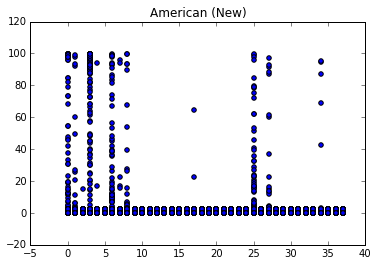

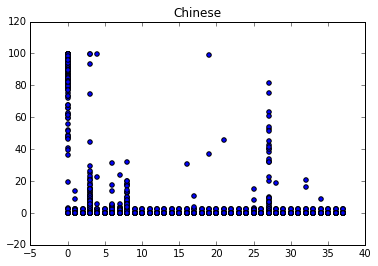

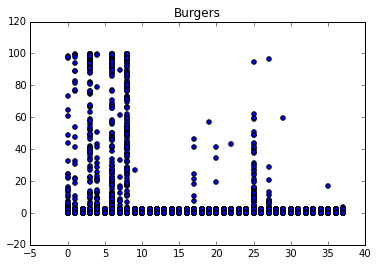

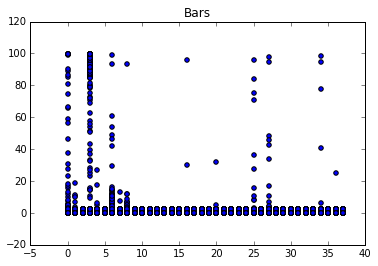

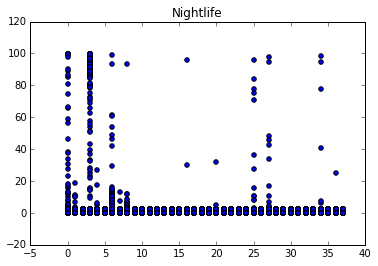

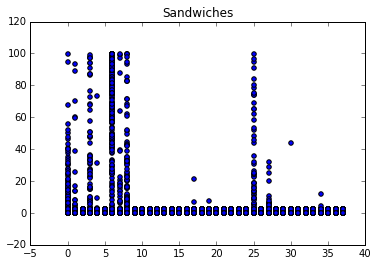

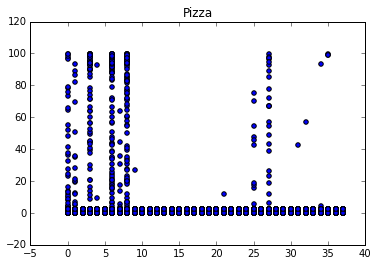

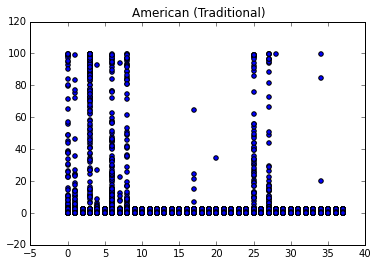

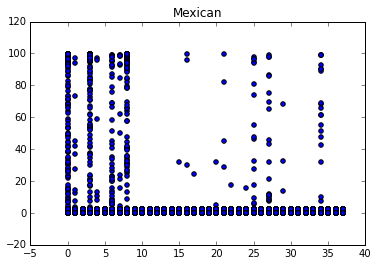

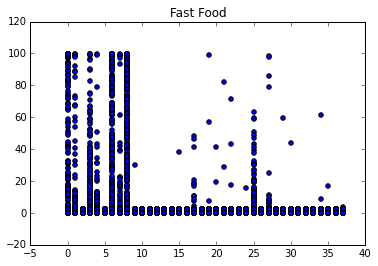

In [170]:
# Own Lda after cleaning 
for category in top10_categories:
    for i, row in gamma_exp[gamma_exp[category]][gamma_exp.columns[-38:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

In [130]:
gamma_package_df.mean()

0     0.025152
1     0.013591
2     0.029110
3     0.028940
4     0.034545
5     0.024500
6     0.056303
7     0.027131
8     0.017025
9     0.124803
10    0.007256
11    0.037298
12    0.010779
13    0.024945
14    0.022074
15    0.034796
16    0.011952
17    0.018278
18    0.012112
19    0.032617
20    0.024301
21    0.014528
22    0.013772
23    0.014565
24    0.018212
25    0.008283
26    0.010942
27    0.007962
28    0.005105
29    0.010541
30    0.009315
31    0.017996
32    0.007173
33    0.011209
34    0.006414
35    0.020517
36    0.005675
37    0.129807
38    0.031824
39    0.038651
dtype: float64

In [132]:
gamma_package_df.std()

0     0.059575
1     0.051710
2     0.084562
3     0.058546
4     0.104929
5     0.059257
6     0.068194
7     0.078508
8     0.056012
9     0.149362
10    0.031952
11    0.109730
12    0.040124
13    0.081334
14    0.091592
15    0.056171
16    0.029787
17    0.072171
18    0.050725
19    0.091210
20    0.066649
21    0.064883
22    0.063464
23    0.058493
24    0.062928
25    0.025081
26    0.037623
27    0.032174
28    0.033012
29    0.061393
30    0.037582
31    0.076591
32    0.035153
33    0.040101
34    0.022871
35    0.061387
36    0.029389
37    0.065676
38    0.090183
39    0.111757
dtype: float64

From the bad results in the supervised learning methdos, we explored the data and discovered that some topics were over represented without carrying any information. Theyre are strongly activated for each category, they are unraveled bi their really high mean and variance.

We run some models without them (after renormalizing)

In [36]:
# Dropping the two topics with the highest mean
gamma_df_clean = gamma_df.drop([22, 30], axis=1)


# Normalizing the new topics distribution
gamma_df_clean = 100 * gamma_df_clean.div(gamma_df_clean.sum(axis=1), axis=0)

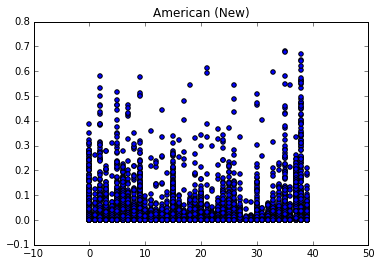

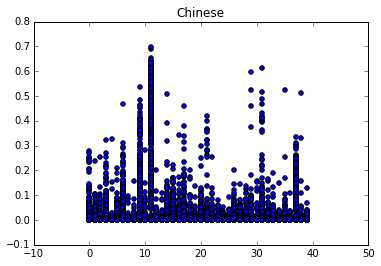

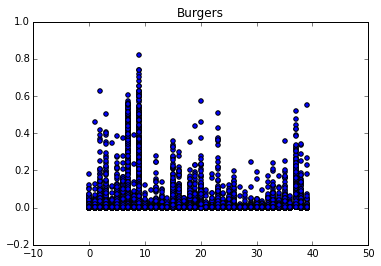

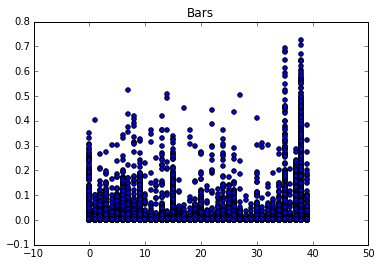

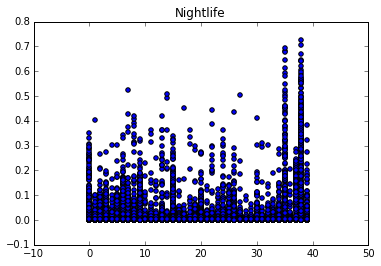

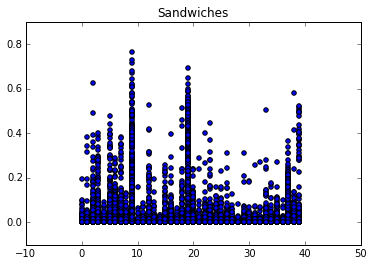

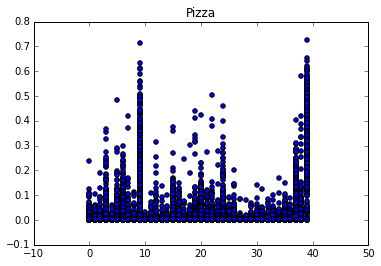

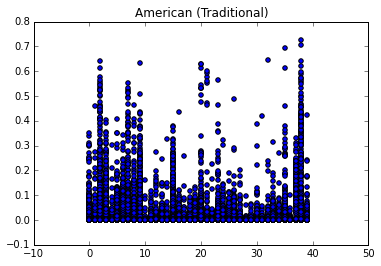

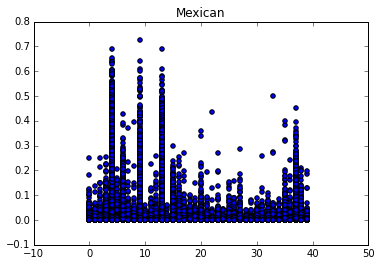

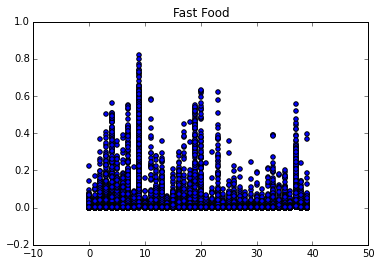

In [171]:
# Package LDA
for category in top10_categories:
    for i, row in gamma_package_exp[gamma_package_exp[category]][gamma_package_exp.columns[-40:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

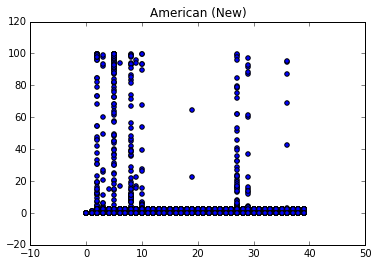

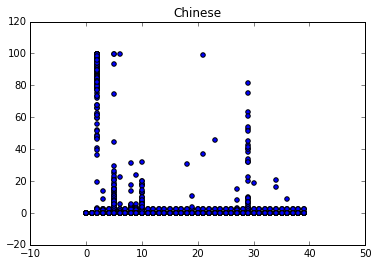

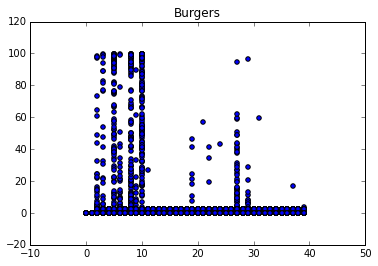

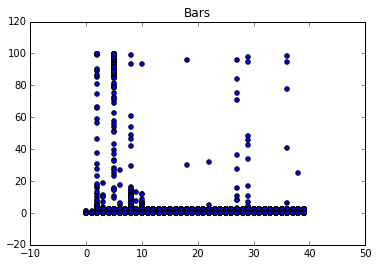

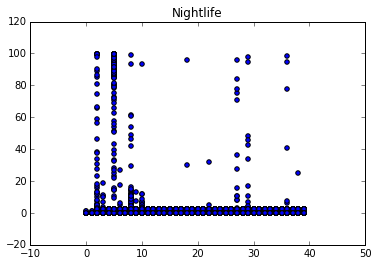

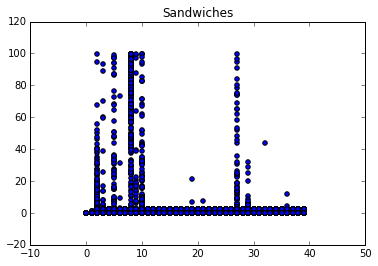

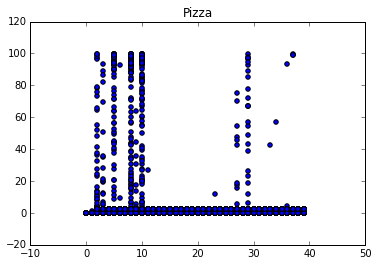

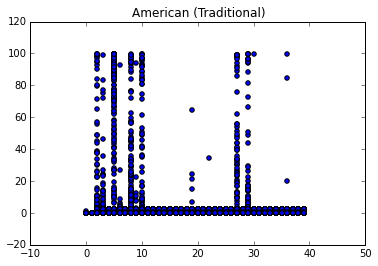

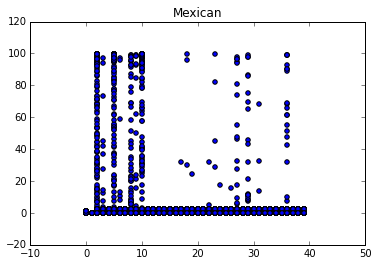

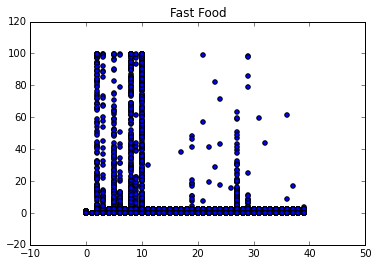

In [194]:
# NMF
for category in top10_categories:
    for i, row in gamma_nmf_exp[gamma_nmf_exp[category]][gamma_nmf_exp.columns[-40:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

# Sample for the graph

In [208]:
selected_categories = [u'Chinese', 'Mexican', 'Seafood']

In [209]:
selected = np.zeros(len(restaurants_lasvegas))
for cat in selected_categories:
    selected += restaurants_lasvegas[cat] == 1

sum(selected == 1)

850

In [215]:
selected_id = restaurants_lasvegas[selected.astype(bool)].index
selected_restaurants_id = selected_id.values

In [ ]:
np.save('temp/')